In [ ]:
# !pip install 'qiskit[visualization]'
# !pip install qiskit_aer
# !pip install qiskit_ibm_runtime

In [2]:
import qiskit
from qiskit import QuantumCircuit
from qiskit import QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_distribution
from qiskit.circuit.library import UnitaryGate
from qiskit.circuit.classical import expr
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.visualization import plot_bloch_vector
from qiskit.visualization.bloch import Bloch
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
import math
import numpy as np
import matplotlib.pyplot as plt

### CHSH game on real quantum computer

Define helper functions.

In [3]:
def is_win(x, y, a, b):
    """
    x, y, a, b are 0 or 1
    return true if x and y = a xor b
    """
    if x==1 and y==1:
        if a != b:
            return True
        else:
            return False
    else:
        if a == b:
            return True
        else:
            return False

In [4]:
def get_win_prob(dist):
    count_win = 0
    count_loss = 0
    for k, v in dist.items():
        x = int(k[3]) # measured bit 0 is rightmost char [3] in string
        y = int(k[2])
        a = int(k[1])
        b = int(k[0])
        if is_win(x, y, a, b):
            count_win += v
        else:
            count_loss += v
    return count_win / (count_win + count_loss)

Reuse the quantum circuit in section 1, except the removal of qc.barrier() which degrades the optimization in real quantum computer.

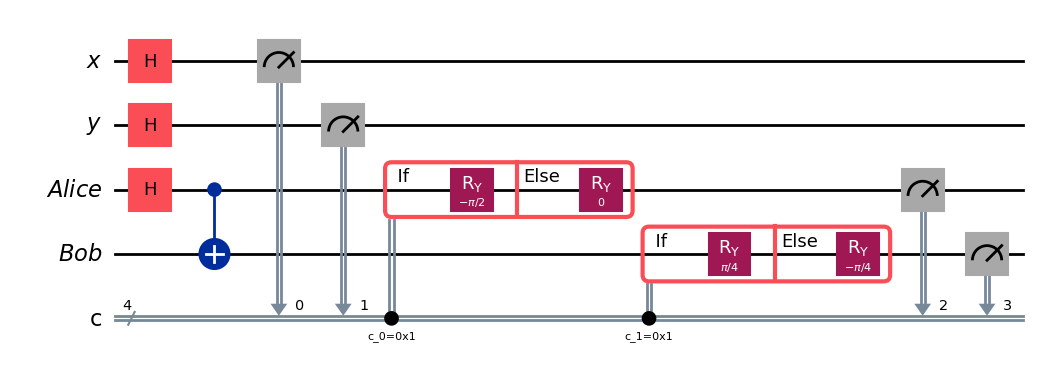

In [5]:
xreg = QuantumRegister(1, "x")
yreg = QuantumRegister(1, "y")
areg = QuantumRegister(1, "Alice")
breg = QuantumRegister(1, "Bob")
c_reg = ClassicalRegister(4, "c") # bit 0, 1, 2, 3 as x, y, a, b

qc = QuantumCircuit(xreg, yreg, areg, breg, c_reg)
qc.h(xreg)
qc.h(yreg)
qc.h(areg)
qc.cx(areg, breg)
# qc.barrier()

# randomly generate x.  Apply Alice's operator accordingly.  Use ry()
qc.measure(xreg, c_reg[0])
with qc.if_test((c_reg[0], 1)) as else_:
    qc.ry(-math.pi/2, areg)
with else_:
    qc.ry(0, areg)
# qc.barrier()

# randomly generate y.  Apply Bob's operator accordingly.  Use ry()
qc.measure(yreg, c_reg[1])
with qc.if_test((c_reg[1], 1)) as else_:
    qc.ry(math.pi/4, breg)
with else_:
    qc.ry(-math.pi/4, breg)
# qc.barrier()

# measure a, b
qc.measure(areg, c_reg[2])
qc.measure(breg, c_reg[3])
display(qc.draw('mpl'))

In [6]:
service = QiskitRuntimeService(channel="ibm_quantum", token="put_token_here")
backend = service.backend(name='ibm_kyiv')
pm = generate_preset_pass_manager(optimization_level=1, backend=backend)

qc_transpiled = pm.run(qc)

In [7]:
sampler = Sampler(mode=backend)
job = sampler.run([qc_transpiled])
# print(job.job_id())

In [8]:
result = job.result()[0]
samp_dist = result.data.c.get_counts()
print("sample distribution: ", samp_dist)
print("win probability = ", get_win_prob(samp_dist))

sample distribution:  {'1000': 75, '1101': 408, '0010': 442, '1100': 427, '0000': 402, '1110': 414, '1001': 106, '0101': 101, '1111': 135, '0011': 107, '0111': 415, '1011': 405, '0110': 90, '0100': 74, '0001': 414, '1010': 81}
win probability =  0.812255859375


The win probability is lower than ideal 0.85.

In [9]:
qiskit.__version__

'1.4.0'